## Imports

In [17]:
#Given the non-deterministic nature, random seeds are set for reproducibility
#However, results may still vary at each repeat
import numpy as np
np.random.seed(27)
import tensorflow as tf
from tensorflow import set_random_seed
tf.set_random_seed(99)
import random as rn
rn.seed(1254)

import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

#Module to ignore warnings and make notebooke more clean
import warnings
warnings.filterwarnings('ignore')

## Import data from CSSE John Hopkins

Raw data is imported from the csv file containing COVID-19 live data into dataframe using pandas library

In [3]:
confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

## Data Preprocessing

All the data pre-processing, including data cleaning and aggregation is done adapting the code available at [1]

### Melt data

Following the pre-processing carried out by [1], data is melted to be transformed from wide to long format

In [4]:
dates = confirmed.columns[4:]

confirmed_long = confirmed.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed'
)
deaths_long = deaths.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths'
)
recovered_long = recovered.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered'
)


### Merge dataframes into one table

Dataframes in long format are then merged based on the following variables: Province/State, Country/Region, Date, Lat, Long.
To obtain a single Dataframe (full_table) containing data related to deaths, recovered and cases.

In [7]:
#First merge confirmed and deaths dataframe
full_table = confirmed_long.merge(
  right=deaths_long, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)

#Merge full_table and recovered dataframe into a single dataframe
full_table = full_table.merge(
  right=recovered_long, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)

In [8]:
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0,0,0.0
1,NaN,Albania,41.15330,20.168300,1/22/20,0,0,0.0
2,NaN,Algeria,28.03390,1.659600,1/22/20,0,0,0.0
3,NaN,Andorra,42.50630,1.521800,1/22/20,0,0,0.0
4,NaN,Angola,-11.20270,17.873900,1/22/20,0,0,0.0


## Data Cleaning

Data is now cleaned following [1]. First the data column is convered to datetime format

In [9]:
#Convert to datetime
full_table['Date'] = pd.to_datetime(full_table['Date'])

Them we check for any missing values (NaN) and replace them with 0

In [10]:
#Replace missing values
full_table.isna().sum()

Province/State    86184
Country/Region        0
Lat                 456
Long                456
Date                  0
Confirmed             0
Deaths                0
Recovered          9576
dtype: int64

In [11]:
full_table['Recovered'] = full_table['Recovered'].fillna(0)

### Data aggregation

New columns are added into the final dataframe, including 'Active' which contains the active cases in the given country which is calculated as showed below.

In [12]:
#Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

Data is then aggregated based on the Date and Country/Region variables, in order to get the aggregate data for every Province/State of that Country/Region

In [13]:
#Aggregate country/region wise
full_grouped = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

Finally, columns for daily new cases, new deaths and new recovered cases are calculated and added to the final dataframe

In [14]:
#Adapted from [1]
#New cases, New deaths and New recovered
temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()
mask = temp['Country/Region'] != temp['Country/Region'].shift(1)
temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan
#Renaiming new columns
temp.columns = ['Country/Region', 'Date', 'New cases', 'New deaths', 'New recovered']
#Merging new values
full_grouped = pd.merge(full_grouped, temp, on=['Country/Region', 'Date'])
#Filling missing values with 0
full_grouped = full_grouped.fillna(0)
#Fixing data types
cols = ['New cases', 'New deaths', 'New recovered']
full_grouped[cols] = full_grouped[cols].astype('int')

full_grouped['New cases'] = full_grouped['New cases'].apply(lambda x: 0 if x<0 else x)

Since the experiment focuses only on predicting cases in Italy, Spain, France, Germany and the UK, the data for these countries is saved in a separate dataframe for each country.

In [15]:
uk = full_grouped[full_grouped['Country/Region'] == 'United Kingdom']
italy = full_grouped[full_grouped['Country/Region'] == 'Italy']
spain = full_grouped[full_grouped['Country/Region'] == 'Spain']
france = full_grouped[full_grouped['Country/Region'] == 'France']
germany = full_grouped[full_grouped['Country/Region'] == 'Germany']

## Build LSTM Model

Using as baseline the experiments carried out by [2] and [3] the LSTM models are trained and tested using the optimal configuration found in the previous experiments, detailed in the Project Report.

First, we set the time steps to 5 and the features we want to predict to 1, which means that the previous 5 days are going to be used by the model to predict the next day

In [16]:
#Number of time steps
time_steps = 5  
num_features = 1 

We then initialise the Bi-directional LSTM model with optimal parameters

In [19]:
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(300, activation='relu'), input_shape = (time_steps, num_features)))
#lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(75, activation='relu'))
lstm_model.add(Dense(units = 1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 600)               724800    
_________________________________________________________________
dense (Dense)                (None, 75)                45075     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 76        
Total params: 769,951
Trainable params: 769,951
Non-trainable params: 0
_________________________________________________________________


# UK Pre process data

In [20]:
uk.head()

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered
182,2020-01-22,United Kingdom,0,0,0.0,0.0,0,0,0
374,2020-01-23,United Kingdom,0,0,0.0,0.0,0,0,0
566,2020-01-24,United Kingdom,0,0,0.0,0.0,0,0,0
758,2020-01-25,United Kingdom,0,0,0.0,0.0,0,0,0
950,2020-01-26,United Kingdom,0,0,0.0,0.0,0,0,0


Since the focus of the experiment is on predicting the number of cumulative cases, the column for the Date and the Confirmed are saved into a separate dataframe

In [21]:
confirmed_uk = uk.iloc[:, [0,2]]
confirmed_uk = confirmed_uk.set_index('Date')

In [22]:
#Split train and test set, leave last 30 days for test
train_uk = confirmed_uk[263:383]
test_uk = confirmed_uk[384:414]

In [23]:
len(train_uk)

120

In [24]:
len(test_uk)

30

Data is normalize using MinMaxScaler function, applied to both training and testing

In [25]:
##Scaler to normalize data
scaler = MinMaxScaler()

In [26]:
##Apply scaler on data
scaler.fit(train_uk) 
scaled_train = scaler.transform(train_uk)
scaled_test = scaler.transform(test_uk)
print(scaled_train[-5:])

[[0.97785409]
 [0.98404199]
 [0.98977328]
 [0.99525357]
 [1.        ]]


Data is fit into temporal batches using TimeSeriesGenerator function, to fit the LSTM model

In [27]:
generator = TimeseriesGenerator(scaled_train,scaled_train,length = time_steps,batch_size=10)

### Fit LSTM model

In [28]:
lstm_model.fit_generator(generator,epochs=300)

Epoch 1/300
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
12/12 [==============================] - 3s 219ms/step - loss: 0.1924
Epoch 2/300
12/12 [==============================] - 0s 35ms/step - loss: 0.0399
Epoch 3/300
12/12 [==============================] - 0s 39ms/step - loss: 0.0121
Epoch 4/300
12/12 [==============================] - 1s 48ms/step - loss: 0.0038
Epoch 5/300
12/12 [==============================] - 0s 36ms/step - loss: 4.5284e-04
Epoch 6/300
12/12 [==============================] - 1s 43ms/step - loss: 5.1129e-04
Epoch 7/300
12/12 [==============================] - 0s 41ms/step - loss: 4.0025e-04
Epoch 8/300
12/12 [==============================] - 0s 39ms/step - loss: 3.1461e-04
Epoch 9/300
12/12 [==============================] - 1s 42ms/step - loss: 2.6289e-04
Epoch 10/300
12/12 [==============================] - 1s 44ms/step - loss: 2.2867e-04
Epoch 11/300
12/12 [==============================] - 1s 44ms/step - l

Epoch 186/300
12/12 [==============================] - 0s 36ms/step - loss: 2.4028e-05
Epoch 187/300
12/12 [==============================] - 1s 42ms/step - loss: 3.1226e-05
Epoch 188/300
12/12 [==============================] - 0s 40ms/step - loss: 1.3447e-05
Epoch 189/300
12/12 [==============================] - 0s 35ms/step - loss: 3.8592e-05
Epoch 190/300
12/12 [==============================] - 0s 41ms/step - loss: 3.2865e-05
Epoch 191/300
12/12 [==============================] - 0s 38ms/step - loss: 3.5621e-05
Epoch 192/300
12/12 [==============================] - 0s 38ms/step - loss: 1.2857e-05
Epoch 193/300
12/12 [==============================] - 0s 34ms/step - loss: 5.1354e-05
Epoch 194/300
12/12 [==============================] - 0s 37ms/step - loss: 5.3671e-05
Epoch 195/300
12/12 [==============================] - 1s 43ms/step - loss: 6.4310e-05
Epoch 196/300
12/12 [==============================] - 0s 40ms/step - loss: 1.5423e-04
Epoch 197/300
12/12 [======================

12/12 [==============================] - 0s 33ms/step - loss: 1.5649e-05
Epoch 282/300
12/12 [==============================] - 0s 41ms/step - loss: 1.1278e-05
Epoch 283/300
12/12 [==============================] - 0s 36ms/step - loss: 1.1760e-05
Epoch 284/300
12/12 [==============================] - 1s 42ms/step - loss: 7.0216e-06
Epoch 285/300
12/12 [==============================] - 0s 40ms/step - loss: 4.9241e-06
Epoch 286/300
12/12 [==============================] - 0s 38ms/step - loss: 4.1866e-06
Epoch 287/300
12/12 [==============================] - 0s 40ms/step - loss: 4.3634e-06
Epoch 288/300
12/12 [==============================] - 0s 33ms/step - loss: 4.3165e-06
Epoch 289/300
12/12 [==============================] - 0s 38ms/step - loss: 4.8010e-06
Epoch 290/300
12/12 [==============================] - 0s 40ms/step - loss: 4.2517e-06
Epoch 291/300
12/12 [==============================] - 0s 36ms/step - loss: 4.8058e-06
Epoch 292/300
12/12 [==============================] - 0s

### Make predictions

In [29]:
##Array for storing predictions
test_prediction = []

The model has been training to use the past 5 days to predict the next, thus 5 days are taken initially from the train set to predict the next and so on

In [30]:
##Last time steps are taken from training set
first_eval_batch = scaled_train[-time_steps:]
current_batch = first_eval_batch.reshape(1,time_steps,num_features)

In [31]:
##Prediction in the future
for i in range(len(test_uk)):
    current_pred = lstm_model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

Predictions are scaled, therefore an inverse scaler is applied to the test predictions to obtain actual number confirmed cases

In [32]:
###Inverse scaled data to obtain predictions
true_prediction = scaler.inverse_transform(test_prediction)
true_prediction[:,0]

array([3968768.30800009, 3983327.43755627, 3996935.50432682,
       4009622.46619034, 4021308.83490896, 4032203.51675606,
       4043002.33339167, 4053169.23850822, 4062746.17313576,
       4071781.46931839, 4080353.81641722, 4088532.71671057,
       4096262.64826345, 4103574.36783123, 4110497.4338541 ,
       4117059.40758038, 4123278.66317558, 4129163.98828411,
       4134734.15650988, 4140008.34089518, 4145001.32066011,
       4149728.27446318, 4154201.98433256, 4158436.03117323,
       4162441.99869823, 4166234.66612768, 4169822.42166758,
       4173216.44959259, 4176427.9341774 , 4179465.66306639])

In [33]:
#Add dates in dataframe for 30 days in the future
time_series_array = test_uk.index
for k in range(0):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))
time_series_array

DatetimeIndex(['2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12',
               '2021-02-13', '2021-02-14', '2021-02-15', '2021-02-16',
               '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-20',
               '2021-02-21', '2021-02-22', '2021-02-23', '2021-02-24',
               '2021-02-25', '2021-02-26', '2021-02-27', '2021-02-28',
               '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04',
               '2021-03-05', '2021-03-06', '2021-03-07', '2021-03-08',
               '2021-03-09', '2021-03-10'],
              dtype='datetime64[ns]', name='Date', freq=None)

A new dataframe is created to store Confirmed cases and Confirmed_predicted cases, using the last 30 days for the Date index

In [34]:
uk_forecast = pd.DataFrame(columns=["Confirmed","Confirmed_predicted"],index=time_series_array)
uk_forecast.loc[:,"Confirmed_predicted"] = true_prediction[:,0].round(1)
uk_forecast.loc[:,"Confirmed"] = test_uk["Confirmed"]

In [35]:
uk_forecast

,Confirmed,Confirmed_predicted
Date,,
2021-02-09,3983760,3968768.3
2021-02-10,3996837,3983327.4
2021-02-11,4010380,3996935.5
2021-02-12,4025578,4009622.5
2021-02-13,4038933,4021308.8
2021-02-14,4049924,4032203.5
2021-02-15,4059700,4043002.3
2021-02-16,4070336,4053169.2
2021-02-17,4083096,4062746.2


In order to plot the actual cases against the predictions, these are saved into two separate dataframes

In [36]:
#Place prediction and actual cases in two separate dataframes for plotting
uk_cases = pd.concat([train_uk, test_uk])
uk_predicted = pd.DataFrame(columns=["Confirmed_predicted"],index=time_series_array)
uk_predicted["Confirmed_predicted"] = true_prediction[:,0].round(1)

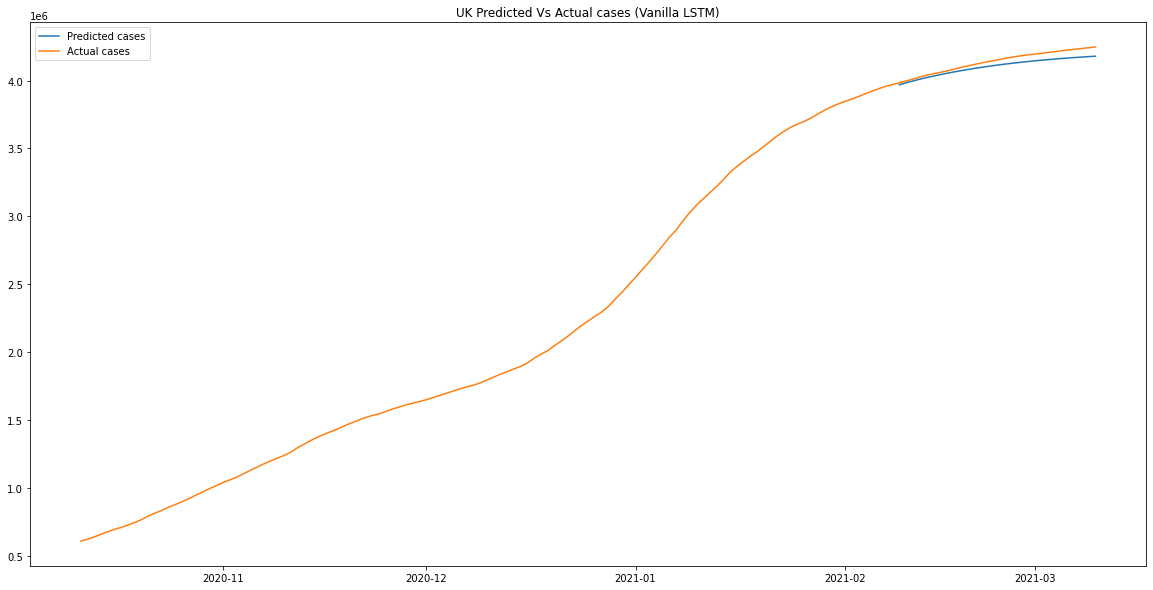

In [37]:
#Plot actual vs predicted
fig, axUK = plt.subplots(figsize = (20,10))
axUK.plot(uk_predicted, label="Predicted cases")
axUK.plot(uk_cases, label="Actual cases")

axUK.set_title('UK Predicted Vs Actual cases (Vanilla LSTM)')

axUK.legend(loc=2)
plt.show()

In [38]:
#Calculate Mean Absolute Percentage Error 
MAPE_uk = np.mean(np.abs(np.array(uk_forecast["Confirmed"][:30]) - np.array(uk_forecast["Confirmed_predicted"][:30]))/np.array(uk_forecast["Confirmed"][:30]))
print("MAPE is " + str(MAPE_uk*100) + " %")

MAPE is 0.9096600354496344 %


Same steps are repeated in order to train and test the LSTM model to the other selected countries

# Italy Pre process data

In [40]:
confirmed_it = italy.iloc[:, [0,2]]
confirmed_it = confirmed_it.set_index('Date')

#Split train and test set, leave last 30 days for test
train_it = confirmed_it[263:383]
test_it = confirmed_it[384:414]

In [41]:
##Apply scaler on data
scaler.fit(train_it) 
scaled_train_it = scaler.transform(train_it)
scaled_test_it = scaler.transform(test_it)
print(scaled_train_it[-5:])

[[0.97679539]
 [0.98278017]
 [0.98900906]
 [0.99489874]
 [1.        ]]


In [42]:
generator_it = TimeseriesGenerator(scaled_train_it,scaled_train_it,length = time_steps,batch_size=10)

### Fit LSTM model

In [43]:
lstm_model.fit_generator(generator_it,epochs=300)

Epoch 1/300
12/12 [==============================] - 0s 36ms/step - loss: 3.0246e-04
Epoch 2/300
12/12 [==============================] - 0s 37ms/step - loss: 5.8616e-04
Epoch 3/300
12/12 [==============================] - 0s 34ms/step - loss: 9.7541e-04
Epoch 4/300
12/12 [==============================] - 0s 37ms/step - loss: 4.7533e-04
Epoch 5/300
12/12 [==============================] - 1s 44ms/step - loss: 1.4494e-04
Epoch 6/300
12/12 [==============================] - 0s 31ms/step - loss: 1.0952e-04
Epoch 7/300
12/12 [==============================] - 1s 44ms/step - loss: 1.4974e-04
Epoch 8/300
12/12 [==============================] - 1s 42ms/step - loss: 7.0788e-05
Epoch 9/300
12/12 [==============================] - 1s 42ms/step - loss: 1.2610e-04
Epoch 10/300
12/12 [==============================] - 0s 36ms/step - loss: 1.0982e-04
Epoch 11/300
12/12 [==============================] - 0s 40ms/step - loss: 8.0856e-05
Epoch 12/300
12/12 [==============================] - 1s 43ms/s

12/12 [==============================] - 1s 53ms/step - loss: 9.1900e-06
Epoch 191/300
12/12 [==============================] - 1s 43ms/step - loss: 1.5585e-05
Epoch 192/300
12/12 [==============================] - 1s 46ms/step - loss: 8.3304e-06
Epoch 193/300
12/12 [==============================] - 1s 50ms/step - loss: 2.1542e-05
Epoch 194/300
12/12 [==============================] - 1s 46ms/step - loss: 6.6689e-06
Epoch 195/300
12/12 [==============================] - 1s 43ms/step - loss: 2.2887e-05
Epoch 196/300
12/12 [==============================] - 1s 49ms/step - loss: 5.2625e-05
Epoch 197/300
12/12 [==============================] - 0s 38ms/step - loss: 7.9300e-05
Epoch 198/300
12/12 [==============================] - 1s 45ms/step - loss: 3.6508e-05: 0s - loss: 3.9931e-
Epoch 199/300
12/12 [==============================] - 1s 50ms/step - loss: 3.8087e-05
Epoch 200/300
12/12 [==============================] - 0s 40ms/step - loss: 1.0002e-04
Epoch 201/300
12/12 [===============

Epoch 284/300
12/12 [==============================] - 0s 36ms/step - loss: 1.7311e-05
Epoch 285/300
12/12 [==============================] - 0s 38ms/step - loss: 2.2161e-05
Epoch 286/300
12/12 [==============================] - 0s 37ms/step - loss: 2.0701e-05
Epoch 287/300
12/12 [==============================] - 0s 37ms/step - loss: 1.3229e-05
Epoch 288/300
12/12 [==============================] - 0s 37ms/step - loss: 1.8935e-05
Epoch 289/300
12/12 [==============================] - 0s 39ms/step - loss: 4.8813e-05
Epoch 290/300
12/12 [==============================] - 0s 36ms/step - loss: 4.7101e-05
Epoch 291/300
12/12 [==============================] - 0s 39ms/step - loss: 2.0068e-04
Epoch 292/300
12/12 [==============================] - 0s 37ms/step - loss: 2.2842e-04
Epoch 293/300
12/12 [==============================] - 0s 37ms/step - loss: 1.7643e-04
Epoch 294/300
12/12 [==============================] - 0s 38ms/step - loss: 6.6103e-04
Epoch 295/300
12/12 [======================

### Make Predictions

In [44]:
#Array for storing predictions
test_prediction_it = []

#Last time steps are taken from training set
first_eval_batch_it = scaled_train_it[-time_steps:]
current_batch_it = first_eval_batch_it.reshape(1,time_steps,num_features)

In [45]:
#Predictions in the future
for i in range(len(test_it)):
    current_pred_it = lstm_model.predict(current_batch_it)[0]
    test_prediction_it.append(current_pred_it)
    current_batch_it = np.append(current_batch_it[:,1:,:],[[current_pred_it]],axis=1)

In [46]:
#Inverse scaled data to obtain predictions
true_prediction_it = scaler.inverse_transform(test_prediction_it)
true_prediction_it[:,0]

array([2525223.01453304, 2511927.69379997, 2498028.78215265,
       2480778.29526877, 2457687.7466774 , 2425294.5809288 ,
       2407874.35960126, 2390388.71979022, 2372326.55409241,
       2353794.76256609, 2335690.29926252, 2320274.38602495,
       2305277.64070034, 2290678.5744729 , 2276600.4080205 ,
       2263245.51702595, 2250757.65894675, 2238777.64414692,
       2227302.75252318, 2216355.01691198, 2205942.32561278,
       2196040.74171686, 2186580.63058066, 2177548.79970336,
       2168925.52833629, 2160701.56812835, 2152855.97428441,
       2145362.22579765, 2138198.4258368 , 2131351.24589586])

In [47]:
it_forecast = pd.DataFrame(columns=["Confirmed","Confirmed_predicted"],index=time_series_array)

In [48]:
it_forecast.loc[:,"Confirmed_predicted"] = true_prediction_it[:,0].round(1)
it_forecast.loc[:,"Confirmed"] = test_it["Confirmed"]

In [49]:
it_forecast

,Confirmed,Confirmed_predicted
Date,,
2021-02-09,2655319,2525223.0
2021-02-10,2668266,2511927.7
2021-02-11,2683403,2498028.8
2021-02-12,2697296,2480778.3
2021-02-13,2710819,2457687.7
2021-02-14,2721879,2425294.6
2021-02-15,2729223,2407874.4
2021-02-16,2739591,2390388.7
2021-02-17,2751657,2372326.6


In [50]:
#Place prediction and actual cases in two separate dataframes for plotting
it_cases = pd.concat([train_it, test_it])
it_predicted = pd.DataFrame(columns=["Confirmed_predicted"],index=time_series_array)
it_predicted["Confirmed_predicted"] = true_prediction_it[:,0].round(1)

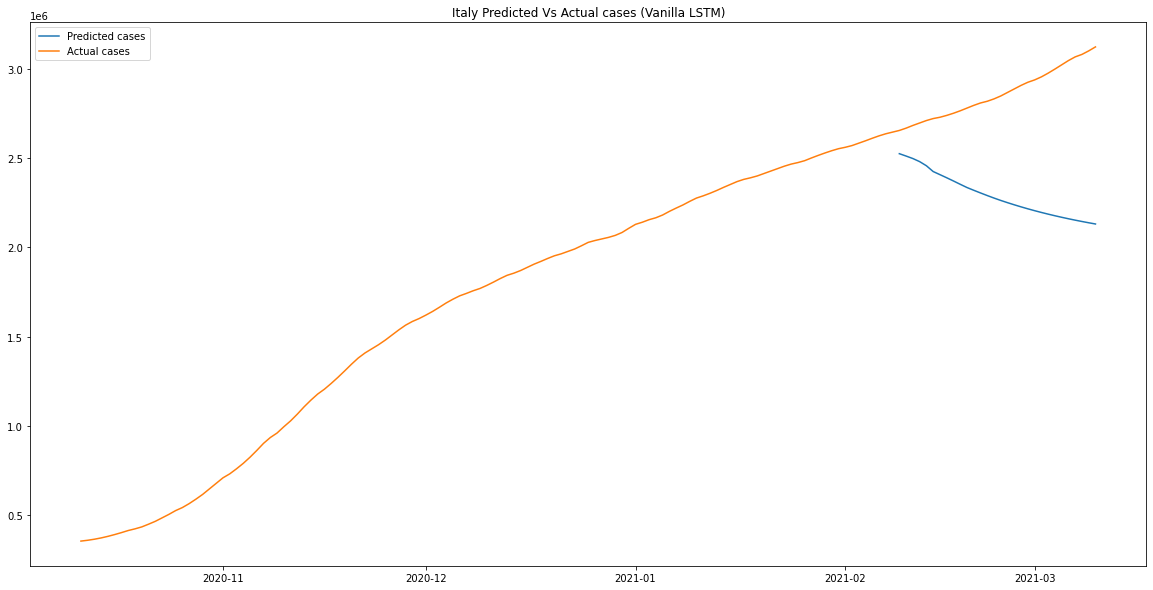

In [51]:
#Plot actual vs predicted
fig, axIT = plt.subplots(figsize = (20,10))
axIT.plot(it_predicted, label="Predicted cases")
axIT.plot(it_cases, label="Actual cases")

axIT.set_title('Italy Predicted Vs Actual cases (Vanilla LSTM)')

axIT.legend(loc=2)
plt.show()

In [52]:
#Calculate Mean Absolute Percentage Error 
MAPE_it = np.mean(np.abs(np.array(it_forecast["Confirmed"][:30]) - np.array(it_forecast["Confirmed_predicted"][:30]))/np.array(it_forecast["Confirmed"][:30]))
print("MAPE is " + str(MAPE_it*100) + " %")

MAPE is 19.51810579312517 %


# Spain Pre process data

In [53]:
confirmed_sp = spain.iloc[:, [0,2]]
confirmed_sp = confirmed_sp.set_index('Date')

#Split train and test set, leave last 30 days for test
train_sp = confirmed_sp[263:383]
test_sp = confirmed_sp[384:414]

In [54]:
##Apply scaler on data
scaler.fit(train_sp) 
scaled_train_sp = scaler.transform(train_sp)
scaled_test_sp = scaler.transform(test_sp)
print(scaled_train_sp[-5:])

[[0.97187485]
 [0.98627262]
 [1.        ]
 [1.        ]
 [1.        ]]


In [55]:
generator_sp = TimeseriesGenerator(scaled_train_sp,scaled_train_sp,length = time_steps,batch_size=10)

### Fit LSTM model

In [56]:
lstm_model.fit_generator(generator_sp,epochs=300)

Epoch 1/300
12/12 [==============================] - 0s 34ms/step - loss: 9.1971e-04
Epoch 2/300
12/12 [==============================] - 0s 37ms/step - loss: 7.9317e-04
Epoch 3/300
12/12 [==============================] - 0s 38ms/step - loss: 9.1663e-04
Epoch 4/300
12/12 [==============================] - 0s 39ms/step - loss: 3.6229e-04
Epoch 5/300
12/12 [==============================] - 0s 39ms/step - loss: 2.1436e-04
Epoch 6/300
12/12 [==============================] - 0s 37ms/step - loss: 2.0991e-04
Epoch 7/300
12/12 [==============================] - 0s 38ms/step - loss: 8.4785e-04
Epoch 8/300
12/12 [==============================] - 0s 38ms/step - loss: 6.8797e-04
Epoch 9/300
12/12 [==============================] - 0s 38ms/step - loss: 2.9196e-04
Epoch 10/300
12/12 [==============================] - 0s 39ms/step - loss: 3.6106e-04
Epoch 11/300
12/12 [==============================] - 0s 38ms/step - loss: 1.8610e-04
Epoch 12/300
12/12 [==============================] - 0s 39ms/s

12/12 [==============================] - 0s 37ms/step - loss: 6.8961e-05
Epoch 97/300
12/12 [==============================] - 0s 37ms/step - loss: 6.3741e-05
Epoch 98/300
12/12 [==============================] - 0s 38ms/step - loss: 7.0227e-05
Epoch 99/300
12/12 [==============================] - 0s 37ms/step - loss: 6.8420e-05
Epoch 100/300
12/12 [==============================] - 0s 37ms/step - loss: 7.0744e-05
Epoch 101/300
12/12 [==============================] - 0s 38ms/step - loss: 7.3445e-05
Epoch 102/300
12/12 [==============================] - 0s 38ms/step - loss: 8.2504e-05
Epoch 103/300
12/12 [==============================] - 0s 37ms/step - loss: 8.8731e-05
Epoch 104/300
12/12 [==============================] - 0s 41ms/step - loss: 6.9838e-05
Epoch 105/300
12/12 [==============================] - 0s 38ms/step - loss: 8.3805e-05
Epoch 106/300
12/12 [==============================] - 0s 38ms/step - loss: 1.2011e-04
Epoch 107/300
12/12 [==============================] - 0s 36

12/12 [==============================] - 0s 33ms/step - loss: 6.7200e-05
Epoch 285/300
12/12 [==============================] - 0s 33ms/step - loss: 7.4078e-05
Epoch 286/300
12/12 [==============================] - 0s 29ms/step - loss: 7.9562e-05
Epoch 287/300
12/12 [==============================] - 0s 29ms/step - loss: 1.1702e-04
Epoch 288/300
12/12 [==============================] - 0s 29ms/step - loss: 2.9690e-04
Epoch 289/300
12/12 [==============================] - 0s 28ms/step - loss: 1.4248e-04
Epoch 290/300
12/12 [==============================] - 0s 29ms/step - loss: 1.6299e-04
Epoch 291/300
12/12 [==============================] - 0s 29ms/step - loss: 4.4537e-04
Epoch 292/300
12/12 [==============================] - 0s 30ms/step - loss: 5.7829e-04
Epoch 293/300
12/12 [==============================] - 0s 29ms/step - loss: 2.9552e-04
Epoch 294/300
12/12 [==============================] - 0s 32ms/step - loss: 3.7563e-04
Epoch 295/300
12/12 [==============================] - 1s

### Make Predictions

In [57]:
#Array for storing predictions
test_prediction_sp = []

#Last time steps are taken from training set
first_eval_batch_sp = scaled_train_sp[-time_steps:]
current_batch_sp = first_eval_batch_sp.reshape(1,time_steps,num_features)

In [58]:
##Prediction in the future
for i in range(len(test_sp)):
    current_pred_sp = lstm_model.predict(current_batch_sp)[0]
    test_prediction_sp.append(current_pred_sp)
    current_batch_sp = np.append(current_batch_sp[:,1:,:],[[current_pred_sp]],axis=1)

In [59]:
###Inverse scaled data to obtain predictions
true_prediction_sp = scaler.inverse_transform(test_prediction_sp)
true_prediction_sp[:,0]

array([3031051.22555947, 3063520.29351163, 3091382.14330626,
       3116632.41754699, 3145327.99696136, 3181425.93447828,
       3208549.06162858, 3233870.0329659 , 3258325.52300501,
       3282618.78181195, 3306448.66456127, 3328077.26297688,
       3348563.79320765, 3368127.78834295, 3386840.44159937,
       3404614.43586111, 3421326.23725414, 3437148.49553013,
       3452145.70628595, 3466343.66776037, 3479761.23251247,
       3492420.72594118, 3504376.22512388, 3515665.68323874,
       3526318.12330437, 3536362.56833935, 3545829.52972221,
       3554751.5033114 , 3563155.52764559, 3571066.90484357])

In [60]:
sp_forecast = pd.DataFrame(columns=["Confirmed","Confirmed_predicted"],index=time_series_array)

In [61]:
sp_forecast.loc[:,"Confirmed_predicted"] = true_prediction_sp[:,0].round(1)
sp_forecast.loc[:,"Confirmed"] = test_sp["Confirmed"]

In [62]:
sp_forecast

,Confirmed,Confirmed_predicted
Date,,
2021-02-09,3005487,3031051.2
2021-02-10,3023601,3063520.3
2021-02-11,3041454,3091382.1
2021-02-12,3056035,3116632.4
2021-02-13,3056035,3145328.0
2021-02-14,3056035,3181425.9
2021-02-15,3086286,3208549.1
2021-02-16,3096343,3233870.0
2021-02-17,3107172,3258325.5


In [63]:
#Place prediction and actual cases in two separate dataframes for plotting
sp_cases = pd.concat([train_sp, test_sp])
sp_predicted = pd.DataFrame(columns=["Confirmed_predicted"],index=time_series_array)
sp_predicted["Confirmed_predicted"] = true_prediction_sp[:,0].round(1)

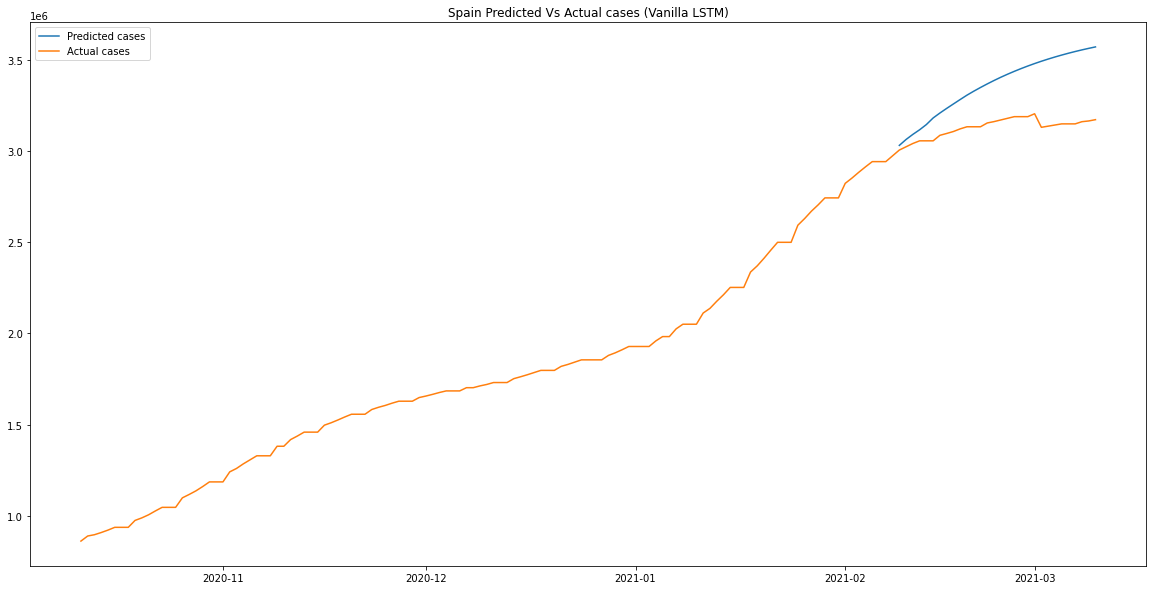

In [64]:
#Plot actual vs predicted
fig, axSP = plt.subplots(figsize = (20,10))
axSP.plot(sp_predicted, label="Predicted cases")
axSP.plot(sp_cases, label="Actual cases")

axSP.set_title('Spain Predicted Vs Actual cases (Vanilla LSTM)')

axSP.legend(loc=2)
plt.show()

In [65]:
#Calculate Mean Absolute Percentage Error 
MAPE_sp = np.mean(np.abs(np.array(sp_forecast["Confirmed"][:30]) - np.array(sp_forecast["Confirmed_predicted"][:30]))/np.array(sp_forecast["Confirmed"][:30]))
print("MAPE is " + str(MAPE_sp*100) + " %")

MAPE is 7.393534603609779 %


# France Pre process data

In [66]:
confirmed_fr = france.iloc[:, [0,2]]
confirmed_fr = confirmed_fr.set_index('Date')

#Split train and test set, leave last 30 days for test
train_fr = confirmed_fr[263:383]
test_fr = confirmed_fr[384:414]

In [67]:
##Apply scaler on data
scaler.fit(train_fr) 
scaled_train_fr = scaler.transform(train_fr)
scaled_test_fr = scaler.transform(test_fr)
print(scaled_train_fr[-5:])

[[0.96718479]
 [0.96719243]
 [0.98460897]
 [0.99247118]
 [1.        ]]


In [68]:
generator_fr = TimeseriesGenerator(scaled_train_fr,scaled_train_fr,length = time_steps,batch_size=10)

### Fit LSTM model

In [69]:
lstm_model.fit_generator(generator_fr,epochs=300)

Epoch 1/300
12/12 [==============================] - 0s 30ms/step - loss: 5.3210e-04
Epoch 2/300
12/12 [==============================] - 0s 29ms/step - loss: 0.0011
Epoch 3/300
12/12 [==============================] - 0s 29ms/step - loss: 8.9393e-04
Epoch 4/300
12/12 [==============================] - 0s 30ms/step - loss: 3.9156e-04
Epoch 5/300
12/12 [==============================] - 0s 30ms/step - loss: 1.6178e-04
Epoch 6/300
12/12 [==============================] - 0s 29ms/step - loss: 5.7588e-05
Epoch 7/300
12/12 [==============================] - 0s 30ms/step - loss: 6.0812e-05
Epoch 8/300
12/12 [==============================] - 0s 30ms/step - loss: 5.3785e-05
Epoch 9/300
12/12 [==============================] - 0s 29ms/step - loss: 3.3742e-05
Epoch 10/300
12/12 [==============================] - 0s 32ms/step - loss: 3.3315e-05
Epoch 11/300
12/12 [==============================] - 0s 35ms/step - loss: 4.5157e-05
Epoch 12/300
12/12 [==============================] - 0s 30ms/step 

12/12 [==============================] - 0s 36ms/step - loss: 2.6881e-05
Epoch 191/300
12/12 [==============================] - 0s 41ms/step - loss: 3.1922e-05
Epoch 192/300
12/12 [==============================] - 0s 38ms/step - loss: 3.3224e-05
Epoch 193/300
12/12 [==============================] - 0s 39ms/step - loss: 5.0517e-05
Epoch 194/300
12/12 [==============================] - 0s 38ms/step - loss: 5.1932e-05
Epoch 195/300
12/12 [==============================] - 1s 49ms/step - loss: 8.2708e-05
Epoch 196/300
12/12 [==============================] - 1s 45ms/step - loss: 6.4043e-05
Epoch 197/300
12/12 [==============================] - 0s 41ms/step - loss: 6.1566e-05
Epoch 198/300
12/12 [==============================] - 1s 42ms/step - loss: 8.8210e-05
Epoch 199/300
12/12 [==============================] - 1s 45ms/step - loss: 2.1763e-04
Epoch 200/300
12/12 [==============================] - 1s 42ms/step - loss: 3.3139e-04
Epoch 201/300
12/12 [==============================] - 0s

### Make Predictions

In [70]:
#Array for storing predictions
test_prediction_fr = []

#Last time steps are taken from training set
first_eval_batch_fr = scaled_train_fr[-time_steps:]
current_batch_fr = first_eval_batch_fr.reshape(1,time_steps,num_features)

In [71]:
##Prediction in the future
for i in range(len(test_fr)):
    current_pred_fr = lstm_model.predict(current_batch_fr)[0]
    test_prediction_fr.append(current_pred_fr)
    current_batch_fr = np.append(current_batch_fr[:,1:,:],[[current_pred_fr]],axis=1)

In [72]:
###Inverse scaled data to obtain predictions
true_prediction_fr = scaler.inverse_transform(test_prediction_fr)
true_prediction_fr[:,0]

array([3403476.31705773, 3419345.68664932, 3440027.96692336,
       3457237.44713628, 3473521.67976439, 3488496.08146608,
       3504680.42231715, 3521231.55328703, 3537134.94851518,
       3552698.39953959, 3568017.74003386, 3583382.96831322,
       3598551.84681833, 3613455.07562888, 3628148.53170764,
       3642664.05555856, 3657021.31337523, 3671168.48629832,
       3684953.23936784, 3698511.0508064 , 3711845.97871745,
       3724968.32444048, 3737864.35285616, 3750511.27615285,
       3762930.00917137, 3775134.28703105, 3787117.24217224,
       3798879.81108034, 3810418.5599755 , 3821738.17128479])

In [73]:
fr_forecast = pd.DataFrame(columns=["Confirmed","Confirmed_predicted"],index=time_series_array)

In [74]:
fr_forecast.loc[:,"Confirmed_predicted"] = true_prediction_fr[:,0].round(1)
fr_forecast.loc[:,"Confirmed"] = test_fr["Confirmed"]

In [75]:
fr_forecast

,Confirmed,Confirmed_predicted
Date,,
2021-02-09,3419210,3403476.3
2021-02-10,3444888,3419345.7
2021-02-11,3465964,3440028.0
2021-02-12,3486673,3457237.4
2021-02-13,3507904,3473521.7
2021-02-14,3524450,3488496.1
2021-02-15,3528856,3504680.4
2021-02-16,3548452,3521231.6
2021-02-17,3573638,3537134.9


In [76]:
#Place prediction and actual cases in two separate dataframes for plotting
fr_cases = pd.concat([train_fr, test_fr])
fr_predicted = pd.DataFrame(columns=["Confirmed_predicted"],index=time_series_array)
fr_predicted["Confirmed_predicted"] = true_prediction_fr[:,0].round(1)

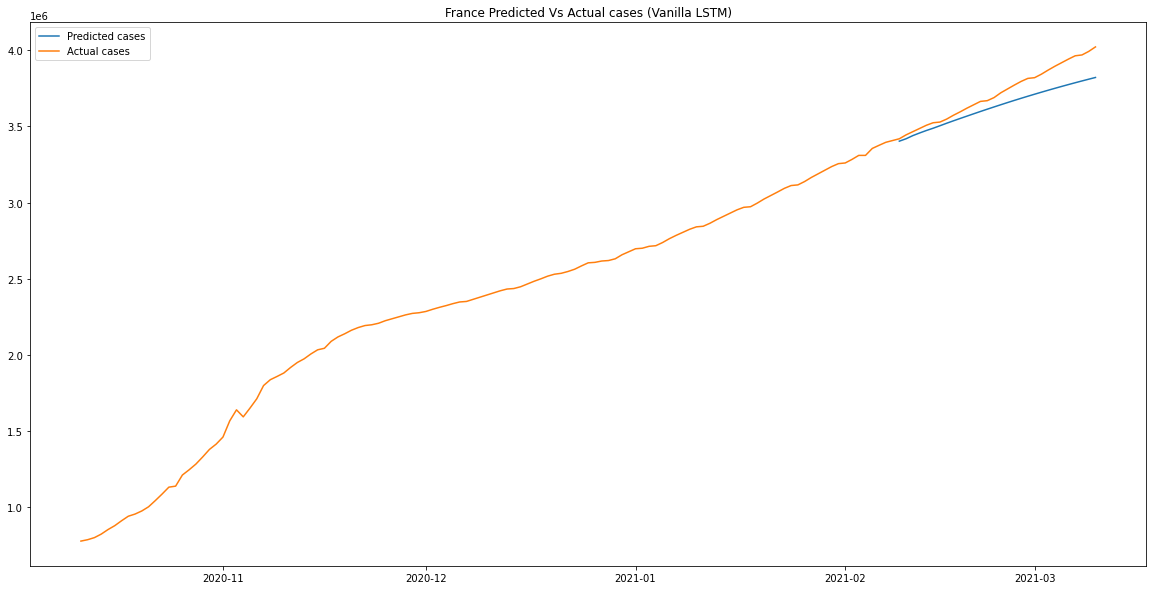

In [77]:
#Plot actual vs predicted
fig, axFR = plt.subplots(figsize = (20,10))
axFR.plot(fr_predicted, label="Predicted cases")
axFR.plot(fr_cases, label="Actual cases")

axFR.set_title('France Predicted Vs Actual cases (Vanilla LSTM)')

axFR.legend(loc=2)
plt.show()

In [78]:
#Calculate Mean Absolute Percentage Error 
MAPE_fr = np.mean(np.abs(np.array(fr_forecast["Confirmed"][:30]) - np.array(fr_forecast["Confirmed_predicted"][:30]))/np.array(fr_forecast["Confirmed"][:30]))
print("MAPE is " + str(MAPE_fr*100) + " %")

MAPE is 2.309444063738569 %


# Germany Pre process data

In [79]:
confirmed_ge = germany.iloc[:, [0,2]]
confirmed_ge = confirmed_ge.set_index('Date')

#Split train and test set, leave last 30 days for test
train_ge = confirmed_ge[263:383]
test_ge = confirmed_ge[384:414]

In [80]:
##Apply scaler on data
scaler.fit(train_ge) 
scaled_train_ge = scaler.transform(train_ge)
scaled_test_ge = scaler.transform(test_ge)
print(scaled_train_ge[-5:])

[[0.98007036]
 [0.98670119]
 [0.99221416]
 [0.99660623]
 [1.        ]]


In [81]:
generator_ge = TimeseriesGenerator(scaled_train_ge,scaled_train_ge,length = time_steps,batch_size=10)

### Fit LSTM model

In [82]:
lstm_model.fit_generator(generator_ge,epochs=300)

Epoch 1/300
12/12 [==============================] - 0s 38ms/step - loss: 2.9560e-04
Epoch 2/300
12/12 [==============================] - 1s 50ms/step - loss: 4.3503e-04
Epoch 3/300
12/12 [==============================] - 1s 50ms/step - loss: 2.0572e-04
Epoch 4/300
12/12 [==============================] - 1s 45ms/step - loss: 2.8516e-04
Epoch 5/300
12/12 [==============================] - 1s 49ms/step - loss: 1.8741e-04
Epoch 6/300
12/12 [==============================] - 1s 44ms/step - loss: 2.0124e-04
Epoch 7/300
12/12 [==============================] - 1s 50ms/step - loss: 5.9729e-05
Epoch 8/300
12/12 [==============================] - 1s 49ms/step - loss: 6.1361e-05
Epoch 9/300
12/12 [==============================] - 0s 40ms/step - loss: 8.4477e-05
Epoch 10/300
12/12 [==============================] - 1s 43ms/step - loss: 1.1504e-04
Epoch 11/300
12/12 [==============================] - 0s 42ms/step - loss: 3.2518e-04
Epoch 12/300
12/12 [==============================] - 1s 43ms/s

12/12 [==============================] - 0s 30ms/step - loss: 4.7285e-05
Epoch 191/300
12/12 [==============================] - 0s 29ms/step - loss: 7.5549e-05
Epoch 192/300
12/12 [==============================] - 0s 30ms/step - loss: 3.5734e-05
Epoch 193/300
12/12 [==============================] - 0s 31ms/step - loss: 3.9642e-05
Epoch 194/300
12/12 [==============================] - 0s 39ms/step - loss: 4.2949e-05
Epoch 195/300
12/12 [==============================] - 0s 37ms/step - loss: 3.5424e-05
Epoch 196/300
12/12 [==============================] - 0s 37ms/step - loss: 4.1492e-05
Epoch 197/300
12/12 [==============================] - 0s 36ms/step - loss: 3.3125e-05
Epoch 198/300
12/12 [==============================] - 0s 32ms/step - loss: 6.9814e-05
Epoch 199/300
12/12 [==============================] - 0s 35ms/step - loss: 5.6553e-05
Epoch 200/300
12/12 [==============================] - 0s 29ms/step - loss: 3.7705e-05
Epoch 201/300
12/12 [==============================] - 0s

12/12 [==============================] - 0s 36ms/step - loss: 2.5391e-05
Epoch 285/300
12/12 [==============================] - 0s 35ms/step - loss: 2.6058e-05
Epoch 286/300
12/12 [==============================] - 0s 39ms/step - loss: 2.9206e-05
Epoch 287/300
12/12 [==============================] - 1s 46ms/step - loss: 2.7934e-05
Epoch 288/300
12/12 [==============================] - 0s 34ms/step - loss: 2.9950e-05
Epoch 289/300
12/12 [==============================] - 0s 38ms/step - loss: 3.7989e-05
Epoch 290/300
12/12 [==============================] - 0s 40ms/step - loss: 3.4560e-05
Epoch 291/300
12/12 [==============================] - 0s 40ms/step - loss: 7.2150e-05
Epoch 292/300
12/12 [==============================] - 1s 49ms/step - loss: 4.6014e-05
Epoch 293/300
12/12 [==============================] - 1s 58ms/step - loss: 1.1437e-04
Epoch 294/300
12/12 [==============================] - 1s 50ms/step - loss: 1.2665e-04
Epoch 295/300
12/12 [==============================] - 0s

### Make Predictions

In [83]:
#Array for storing predictions
test_prediction_ge = []

#Last time steps are taken from training set
first_eval_batch_ge = scaled_train_ge[-time_steps:]
current_batch_ge = first_eval_batch_ge.reshape(1,time_steps,num_features)

In [84]:
##Prediction in the future
for i in range(len(test_ge)):
    current_pred_ge = lstm_model.predict(current_batch_ge)[0]
    test_prediction_ge.append(current_pred_ge)
    current_batch_ge = np.append(current_batch_ge[:,1:,:],[[current_pred_ge]],axis=1)

In [85]:
###Inverse scaled data to obtain predictions
true_prediction_ge = scaler.inverse_transform(test_prediction_ge)
true_prediction_ge[:,0]

array([2301066.37478304, 2310102.69214535, 2318616.77788639,
       2326406.90862083, 2333843.73056889, 2341447.36674499,
       2348789.30138636, 2355819.39650869, 2362555.69241476,
       2369075.97326708, 2375442.32582188, 2381605.31496382,
       2387557.67771387, 2393307.61420965, 2398875.50765037,
       2404271.90107012, 2409494.68586206, 2414549.25068808,
       2419440.04705143, 2424173.86935186, 2428755.63767195,
       2433189.33493566, 2437481.9898324 , 2441637.11670685,
       2445657.76132441, 2449549.31234693, 2453314.58125019,
       2456958.01953745, 2460485.01587057, 2463898.61601496])

In [86]:
ge_forecast = pd.DataFrame(columns=["Confirmed","Confirmed_predicted"],index=time_series_array)

In [87]:
ge_forecast.loc[:,"Confirmed_predicted"] = true_prediction_ge[:,0].round(1)
ge_forecast.loc[:,"Confirmed"] = test_ge["Confirmed"]

In [88]:
ge_forecast

,Confirmed,Confirmed_predicted
Date,,
2021-02-09,2302051,2301066.4
2021-02-10,2311297,2310102.7
2021-02-11,2321225,2318616.8
2021-02-12,2330422,2326406.9
2021-02-13,2336906,2333843.7
2021-02-14,2341744,2341447.4
2021-02-15,2346876,2348789.3
2021-02-16,2352766,2355819.4
2021-02-17,2362364,2362555.7


In [89]:
#Place prediction and actual cases in two separate dataframes for plotting
ge_cases = pd.concat([train_ge, test_ge])
ge_predicted = pd.DataFrame(columns=["Confirmed_predicted"],index=time_series_array)
ge_predicted["Confirmed_predicted"] = true_prediction_ge[:,0].round(1)

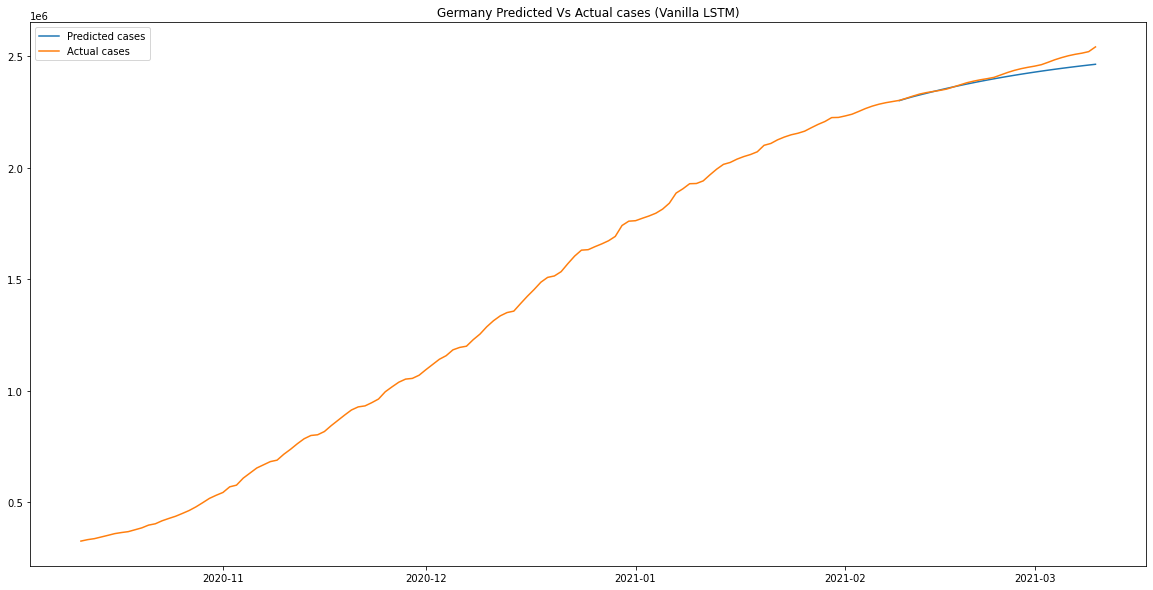

In [90]:
#Plot actual vs predicted
fig, axGE = plt.subplots(figsize = (20,10))
axGE.plot(ge_predicted, label="Predicted cases")
axGE.plot(ge_cases, label="Actual cases")

axGE.set_title('Germany Predicted Vs Actual cases (Vanilla LSTM)')

axGE.legend(loc=2)
plt.show()

In [91]:
#Calculate Mean Absolute Percentage Error 
MAPE_ge = np.mean(np.abs(np.array(ge_forecast["Confirmed"][:30]) - np.array(ge_forecast["Confirmed_predicted"][:30]))/np.array(ge_forecast["Confirmed"][:30]))
print("MAPE is " + str(MAPE_ge*100) + " %")

MAPE is 0.8591916899148884 %


## Collect Results

Dataframe to collect results for the current repeat using MAPE to evaluate performance

In [114]:
countries = ['Uk','Italy','Spain','France','Germany']
mape = [MAPE_uk*100, MAPE_it*100, MAPE_sp*100, MAPE_fr*100, MAPE_ge*100]
pd.DataFrame([mape],columns=[countries],index=['MAPE'])

,Uk,Italy,Spain,France,Germany
MAPE,5.686393,1.599498,1.002417,5.407144,0.734906


Given the non-deterministic nature of the consequent experiments and the instability of the models, these were run for 10 times and the average MAPE was calculated for every selected country.

In [101]:
countries = ['Uk','Italy','Spain','France','Germany']
avg_mapeBi = [4.1469, 2.7047, 3.3306, 2.9704, 1.9988]
pd.DataFrame([avg_mapeBi],columns=[countries],index=['Average MAPE (10 experiments)'])

,Uk,Italy,Spain,France,Germany
Average MAPE (10 experiments),4.1469,2.7047,3.3306,2.9704,1.9988


Finally, the table below compares the Vanilla LSTM average MAPE and the Bi-directional LSTM average MAPE achieved in 10 repeats

In [99]:
avg_mape = [1.6611, 4.0838, 2.6755, 2.9937, 1.0959]
rows = ["Vanilla LSTM", "Bi-directional LSTM"]
data = [avg_mape, avg_mapeBi]
pd.DataFrame(data=data, index=rows, columns=[countries])

,Uk,Italy,Spain,France,Germany
Vanilla LSTM,1.6611,4.0838,2.6755,2.9937,1.0959
Bi-directional LSTM,4.1469,2.7047,3.3306,2.9704,1.9988


Plots for each country, comparing actual Vs predicted cases based on the current repeat of the experiment

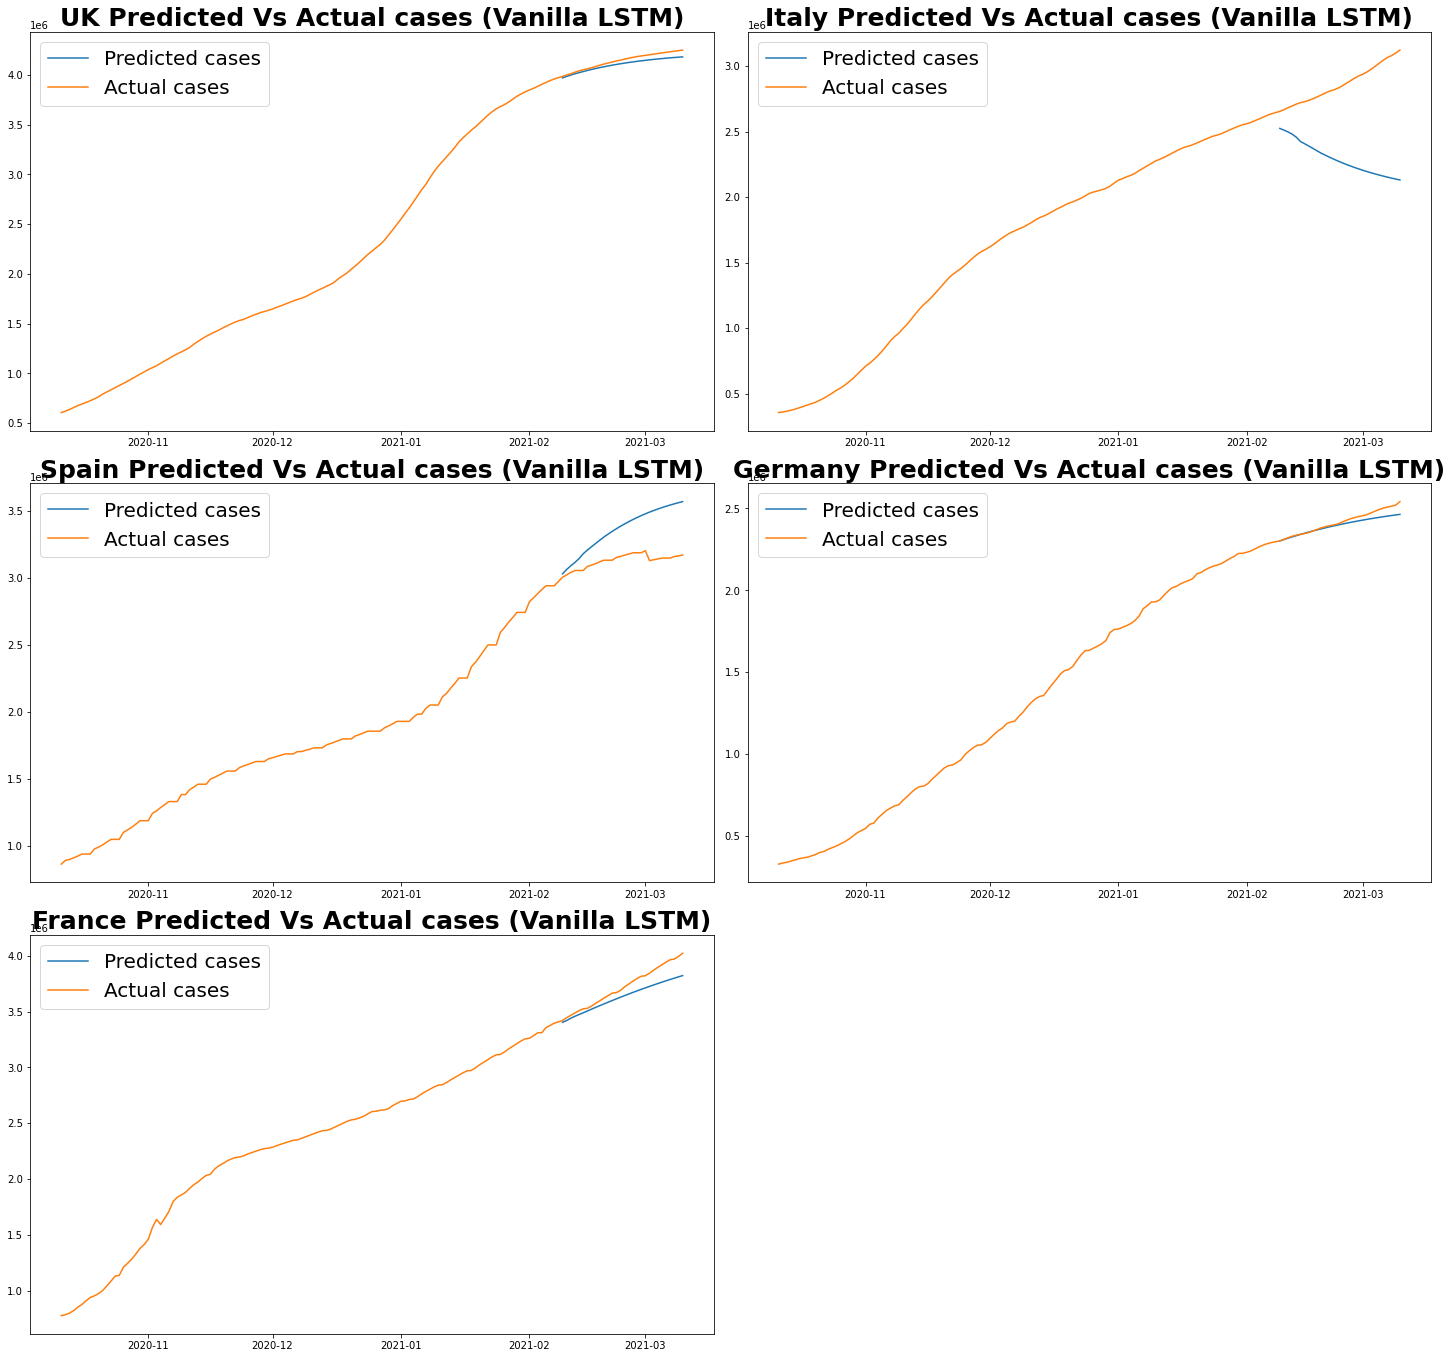

In [94]:
gs = gridspec.GridSpec(4, 4)

fig = plt.figure(figsize=(40,25))

##UK PLOT
axUK = fig.add_subplot(gs[0, 0]) 
axUK.plot(uk_predicted, label="Predicted cases")
axUK.plot(uk_cases, label="Actual cases")
axUK.set_title('UK Predicted Vs Actual cases (Vanilla LSTM)', fontweight="bold", size = 25)
axUK.legend(loc=2, prop={'size': 20})

#ITALY PLOT
axIT = fig.add_subplot(gs[0, 1]) 
axIT.plot(it_predicted, label="Predicted cases")
axIT.plot(it_cases, label="Actual cases")
axIT.set_title('Italy Predicted Vs Actual cases (Vanilla LSTM)', fontweight="bold", size = 25)
axIT.legend(loc=2, prop={'size': 20})

#SPAIN PLOT
axSP = fig.add_subplot(gs[1, 0])
axSP.plot(sp_predicted, label="Predicted cases")
axSP.plot(sp_cases, label="Actual cases")
axSP.set_title('Spain Predicted Vs Actual cases (Vanilla LSTM)', fontweight="bold", size = 25)
axSP.legend(loc=2, prop={'size': 20})


#GERMANY PLOT
axGE = fig.add_subplot(gs[1, 1]) 
axGE.plot(ge_predicted, label="Predicted cases")
axGE.plot(ge_cases, label="Actual cases")
axGE.set_title('Germany Predicted Vs Actual cases (Vanilla LSTM)', fontweight="bold", size = 25)
axGE.legend(loc=2, prop={'size': 20})


#FRANCE PLOT
axFR = fig.add_subplot(gs[2, 0])
axFR.plot(fr_predicted, label="Predicted cases")
axFR.plot(fr_cases, label="Actual cases")
axFR.set_title('France Predicted Vs Actual cases (Vanilla LSTM)', fontweight="bold", size = 25)
axFR.legend(loc=2, prop={'size': 20})


fig.tight_layout()

In [96]:
#Comment out to save plot as png
#fig.savefig('BiDir_lstmCases.png', dpi=fig.dpi)

## References

[1] https://towardsdatascience.com/covid-19-data-processing-58aaa3663f6

[2] https://github.com/ashukrishna100/COVID19-time-series/blob/master/time%20series%20univariate%20LSTM%20confirmed%20Iran.ipynb

[3] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7437542/